# Spatial Impacts of the Palisades and Eaton Fires in Los Angeles County

Author: Nathalie Bonnet

Github: https://github.com/NatBonnet/eds220-la-fires-eji

## About
This notebook contains the data wrangling and processing to visualize the areas in Los Angeles county impacted by the January 2025 Southern California wildfires. The analyses involved the use of historical fire records from Los Angeles, and were compared using a vegetation map of the LA County area. 

## Highlights
- Landsat data was imported as a NetCDF4 file. `.nc` files contain nested metadata and attributes that make processing less reliant on outside research and interpretation. 
- xarray and rioxarray libraries were used to transform the file aspects as geopandas uses different methods.
- Color bands are contained by landsat data so they can be indexed into to fill rgb bands to create either a true color image or a false color image of choice. 

## Data sources

## Landsat data
Overview:
This dataset is from the Landsat Collection 2 Level-2 atmosperically corrected surface reflectance data, collected by the Landsat 8 satellite. It is a collection of remote sensing data containing red, green, blue, NIR, and SWIR bands. Data was retrieved from the Microsoft Planetary Computer data catalogue and clipped to the area around Palisades/Eaton fire perimeters. 

Landsat 8 Satellite Data: Planetary Computer. Microsoft Planetary Computer [Data Collection]. https://planetarycomputer.microsoft.com/dataset/landsat-c2-l2

## Fires data
Overview:
This dataset was retrieved from the California State Geoportal Historical Wildland Fire Perimeters database. The data include geographic data as well as fire id and date information. 

Fire Perimeter Data: California State Geoportal. California Historical Fire Perimeters [Dataset]. https://gis.data.ca.gov/datasets/CALFIRE-Forestry::california-historical-fire-perimeters/explore?layer=2&location=37.338129%2C-119.269051%2C6.09&showTable=true

Original date of access: 11/19/2025

### Setup

In [9]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import xarray as xr
import rioxarray as rio
import matplotlib.pyplot as plt
from matplotlib_scalebar.scalebar import ScaleBar


Here we are reading in data from the Landsat NetCDF and California Wildfire Perimeters data. 

In [10]:
# Read in datasets
fp = os.path.join('data', 'landsat8-2025-02-23-palisades-eaton.nc')
landsat = xr.open_dataset(fp, engine="netcdf4")

fp = os.path.join('data', 'California_Historic_Fire_Perimeters_-247493000743518952', 'California_Fire_Perimeters_(1950+).shp')
fires = gpd.read_file(fp)

### Data Exploration


Exploration for fires data: Knowing that there will be a spatial join further in the workflow, it is helpful to visualize column names that might need to be joined on and the CRS of the datasets. 

In [11]:
# Look at the head of the fires dataset
fires.head()

,YEAR_,STATE,AGENCY,UNIT_ID,FIRE_NAME,INC_NUM,ALARM_DATE,CONT_DATE,CAUSE,C_METHOD,OBJECTIVE,GIS_ACRES,COMMENTS,COMPLEX_NA,IRWINID,FIRE_NUM,COMPLEX_ID,DECADES,geometry
0,2025,CA,CDF,LDF,PALISADES,00000738,2025-01-07,2025-01-31,14,7,1,23448.900,None,None,{A7EA5D21-F882-44B8-BF64-44AB11059DC1},None,None,2020-January 2025,"MULTIPOLYGON (((-13193558.265 4032826.468, -13..."
1,2025,CA,CDF,LAC,EATON,00009087,2025-01-08,2025-01-31,14,7,1,14056.300,None,None,{72660ADC-B5EF-4D96-A33F-B4EA3740A4E3},None,None,2020-January 2025,"MULTIPOLYGON (((-13146936.686 4051222.067, -13..."
2,2025,CA,CDF,ANF,HUGHES,00250270,2025-01-22,2025-01-28,14,7,1,10396.800,None,None,{994072D2-E154-434A-BB95-6F6C94C40829},None,None,2020-January 2025,"MULTIPOLYGON (((-13197885.239 4107084.744, -13..."
3,2025,CA,CCO,VNC,KENNETH,00003155,2025-01-09,2025-02-04,14,2,1,998.738,from OES Intel 24,None,{842FB37B-7AC8-4700-BB9C-028BF753D149},None,None,2020-January 2025,"POLYGON ((-13211054.577 4051508.758, -13211051..."
4,2025,CA,CDF,LDF,HURST,00003294,2025-01-07,2025-01-09,14,7,1,831.385,None,None,{F4E810AD-CDF3-4ED4-B63F-03D43785BA7B},None,None,2020-January 2025,"POLYGON ((-13187991.688 4073306.403, -13187979..."


In [12]:
# Find datatypes for each column
fires.dtypes

YEAR_            int64
STATE           object
AGENCY          object
UNIT_ID         object
FIRE_NAME       object
INC_NUM         object
ALARM_DATE      object
CONT_DATE       object
CAUSE            int64
C_METHOD         int64
OBJECTIVE        int64
GIS_ACRES      float64
COMMENTS        object
COMPLEX_NA      object
IRWINID         object
FIRE_NUM        object
COMPLEX_ID      object
DECADES         object
geometry      geometry
dtype: object

In [13]:
# Retrieve column names for fire data
fires.columns

Index(['YEAR_', 'STATE', 'AGENCY', 'UNIT_ID', 'FIRE_NAME', 'INC_NUM',
       'ALARM_DATE', 'CONT_DATE', 'CAUSE', 'C_METHOD', 'OBJECTIVE',
       'GIS_ACRES', 'COMMENTS', 'COMPLEX_NA', 'IRWINID', 'FIRE_NUM',
       'COMPLEX_ID', 'DECADES', 'geometry'],
      dtype='object')

In [14]:
# Look for any missing values
fires.isna().sum()

YEAR_             0
STATE             0
AGENCY            1
UNIT_ID          13
FIRE_NAME      2851
INC_NUM         610
ALARM_DATE        0
CONT_DATE         0
CAUSE             0
C_METHOD          0
OBJECTIVE         0
GIS_ACRES         0
COMMENTS      15348
COMPLEX_NA    16940
IRWINID       14399
FIRE_NUM       5494
COMPLEX_ID    16974
DECADES           0
geometry          0
dtype: int64

In [15]:
# Check temporal extent of data
fires.YEAR_.unique()

array([2025, 2024, 2023, 2022, 2021, 2020, 2019, 2018, 2017, 2016, 2015,
       2014, 2013, 2012, 2011, 2010, 2009, 2008, 2007, 2006, 2005, 2004,
       2003, 2002, 2001, 2000, 1999, 1998, 1997, 1996, 1995, 1994, 1993,
       1992, 1991, 1990, 1989, 1988, 1987, 1986, 1985, 1984, 1983, 1982,
       1981, 1980, 1979, 1978, 1977, 1976, 1975, 1974, 1973, 1972, 1971,
       1970, 1969, 1968, 1967, 1966, 1965, 1964, 1963, 1962, 1961, 1960,
       1959, 1958, 1957, 1956, 1955, 1954, 1953, 1952, 1951, 1950])

In [16]:
# Return the CRS of the perimeter data and whether or not the CRS is projected
print(fires.crs)
print(fires.crs.is_projected)

EPSG:3857
True


### Summary of fires data exploration
The perimeter data dates back to 1950 and contains metadata on individual fires. These include the Palisades and Eaton fires. The CRS is EPSG:3857 and is projected, so the data can be mapped as is.

### Landsat data exploration
Now we repeat similar steps to the fires data exploration. However, here we use a NetCDF object. These data structures are beneficial as they contain metadata within the nesting, however they do require slightly different methods using `xarray` and `rioxarray`.

In [17]:
# Return the variables of landsat data (measurements)
landsat.variables

Frozen({'y': <xarray.IndexVariable 'y' (y: 1418)> Size: 11kB
array([3799050., 3799020., 3798990., ..., 3756600., 3756570., 3756540.])
Attributes:
    units:          metre
    resolution:     -30.0
    crs:            EPSG:32611
    axis:           Y
    long_name:      y coordinate of projection
    standard_name:  projection_y_coordinate, 'x': <xarray.IndexVariable 'x' (x: 2742)> Size: 22kB
array([334410., 334440., 334470., ..., 416580., 416610., 416640.])
Attributes:
    units:          metre
    resolution:     30.0
    crs:            EPSG:32611
    axis:           X
    long_name:      x coordinate of projection
    standard_name:  projection_x_coordinate, 'time': <xarray.Variable ()> Size: 8B
[1 values with dtype=datetime64[ns]], 'red': <xarray.Variable (y: 1418, x: 2742)> Size: 16MB
[3888156 values with dtype=float32]
Attributes:
    grid_mapping:  spatial_ref, 'green': <xarray.Variable (y: 1418, x: 2742)> Size: 16MB
[3888156 values with dtype=float32]
Attributes:
    grid_mapp

In [18]:
# Look at the dimensions of landsat data
landsat.dims

FrozenMappingWarningOnValuesAccess({'y': 1418, 'x': 2742})

In [19]:
# Return the coordinates of landsat data
landsat.coords

Coordinates:
  * y        (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x        (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time     datetime64[ns] 8B ...

### Landsat exploration summary
The variables being measured in these data are red, green, blue, NIR, and SWIR reflectance bands with a resolution of 30 meters. This means we can use these data for spatial imgery.

### Restoring geospatial information
CRS is not an object directly stored by `.nc` objects. The spatial extent of the data contains this information, and it must be reassigned to the object itself.

In [20]:
# Try checking the crs of the landsat data 
print(landsat.rio.crs)

None


We can see there is currently no CRS contained in the landsat data itself, but it can be retrieved from the `spatial_ref` of the object.

In [21]:
# Find CRS of spatial reference in landsat data itself
crs = landsat.spatial_ref.crs_wkt

Now it is possible to set the CRS, making it able to join.

In [22]:
# Set the crs of landsat equal to that of the spatial reference
landsat.rio.write_crs(crs, inplace= True)

<xarray.Dataset> Size: 78MB
Dimensions:      (y: 1418, x: 2742)
Coordinates:
  * y            (y) float64 11kB 3.799e+06 3.799e+06 ... 3.757e+06 3.757e+06
  * x            (x) float64 22kB 3.344e+05 3.344e+05 ... 4.166e+05 4.166e+05
    time         datetime64[ns] 8B ...
    spatial_ref  int64 8B 0
Data variables:
    red          (y, x) float32 16MB ...
    green        (y, x) float32 16MB ...
    blue         (y, x) float32 16MB ...
    nir08        (y, x) float32 16MB ...
    swir22       (y, x) float32 16MB ...

In [23]:
# Return set CRS to check this output
print(landsat.rio.crs)

EPSG:32611


### Visualizing landsat data from February 2025 in Los Angeles County
Now with the landsat data, we are interested in visualizing the effects that can be seen on satellite data from the wildfires in LA. We use a true color image at first to get a normal view of the data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


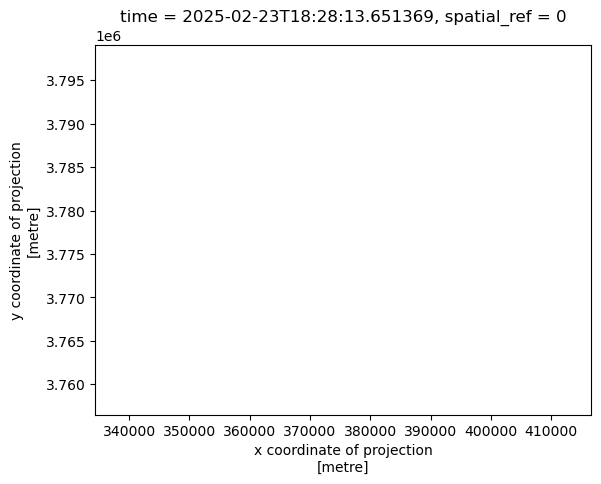

In [24]:
# Try plotting true color image 
landsat[["red", "green", "blue"]].to_array().plot.imshow()

This original plot renders blank. This can possibly occur for multiple reasons but the most likely is that color values are being compressed due to cloud cover, which essentially squeezes values into an inaccurate range that cannot be plotted. This can be fixed using robust = True, which sets the scalar values manually.

/opt/anaconda3/envs/eds220-env/lib/python3.11/site-packages/matplotlib/cm.py:478: RuntimeWarning: invalid value encountered in cast
  xx = (xx * 255).astype(np.uint8)


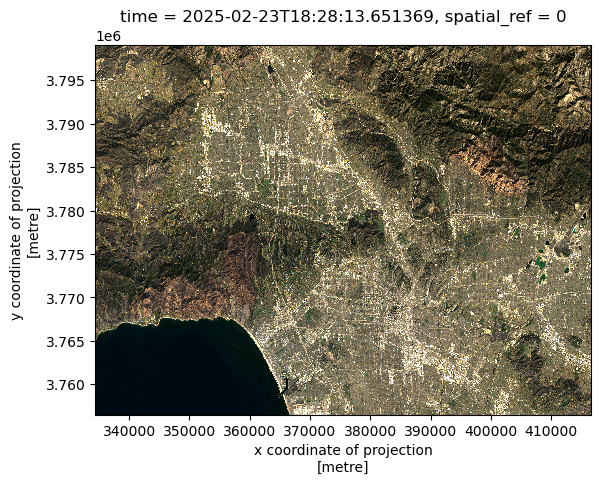

In [25]:
# Adjust for cloud cover in data
landsat[["red", "green", "blue"]].to_array().plot.imshow(robust = True)

There is still a warning present with this code, which describes invalid values. These are most likely NAs that are not able to be plotted. These are able to be removed. Here, we create an array to access any missing values within landsat data.

In [26]:
# Create numpy array with true color bands 
true_col = landsat[["red", "green", "blue"]].to_array()

In [27]:
# Check for missing values in true color array
np.isnan(true_col).any(axis=(1,2))

<xarray.DataArray (variable: 3)> Size: 3B
array([False,  True,  True])
Coordinates:
    time         datetime64[ns] 8B 2025-02-23T18:28:13.651369
    spatial_ref  int64 8B 0
  * variable     (variable) object 24B 'red' 'green' 'blue'

The output here tells us that there are NAs in the green and blue bands. Now they are filled with `fillna()`.

In [28]:
# Fill missing values in landsat data
landsat = landsat.fillna(0)

Now we can produce a final plot without warnings.

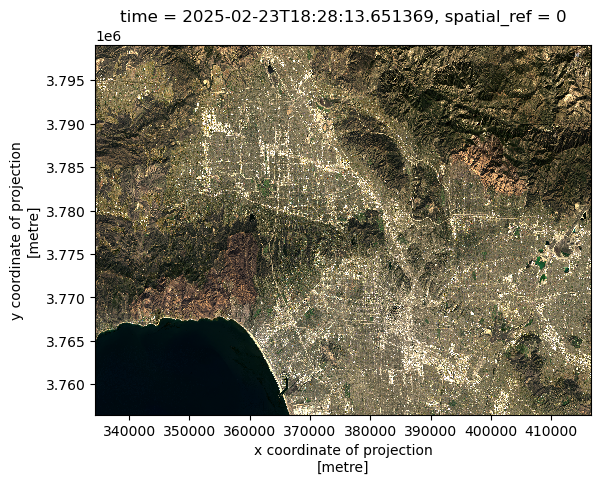

In [29]:
# Rerender plot without warnings
landsat[["red", "green", "blue"]].to_array().plot.imshow(robust = True)

### Review: Why does this work?
The first code chunk `landsat[["red", "green", "blue"]].to_array().plot.imshow()`returns a blank image because clouds skew RBG data so other reflectances are not represented in color scaling. 

### Producing a false color image
A false color image can be created to visualize various natural patterns by switching color bands from their respective places. Here we switch short wave infared into red band, near infared into green band, and red into blue to create false color image


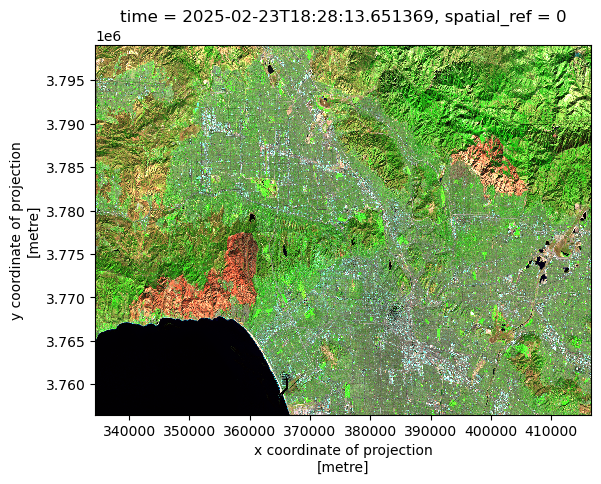

In [30]:
# Switch band order around to create false color image
landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(robust = True)

### Mapping fire perimeters

We can select individual fires out of the fire perimeter dataset by filtering by the fire name and year of observation.

In [31]:
# Filter for Palisades fire data from 2025
palisade_perimeter = fires[(fires['FIRE_NAME'] == 'PALISADES') & (fires['YEAR_'] == 2025)]

# Filter for Eaton fire 2025
eaton_perimeter = fires[(fires['FIRE_NAME'] == 'EATON') & (fires['YEAR_'] == 2025)]

As we know from analysis, the CRS are different between fires and lansat data. We can change these with `to_crs`. 

In [32]:
# Change CRS of fires data to match that of landsat data
palisade_perimeter = palisade_perimeter.to_crs(crs = 'EPSG:32611')
eaton_perimeter = eaton_perimeter.to_crs(crs = 'EPSG:32611')

To create a full false color image emphasizing the burned areas from landsat data, we use the same code for the false color image as above. Here we added the boundary plot of both fire perimeters to confirm the true boundary we see in satellite imagery. We are able to add scalebars and directional arrows with specific packages unpacked in the setup code. Adding labels above the fires and to the relative position of downtown Los Angeles for reference by using `fig.text` options. 

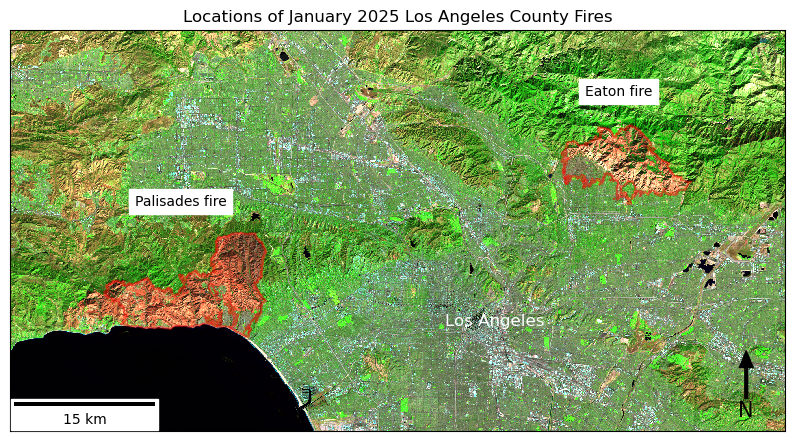

In [ ]:
# Initialize plot
fig, ax = plt.subplots(figsize = (10, 10))

# Underlay landsat false color image plot
landsat[["swir22", "nir08", "red"]].to_array().plot.imshow(ax=ax, 
                                                           robust = True)

# Add Palisade fire area onto plot
palisade_perimeter.boundary.plot(ax=ax, color = 'red', alpha = 0.5)

# Add Eaton fire area onto plot
eaton_perimeter.boundary.plot(ax=ax, color = "red", alpha = 0.5)

# Add informative title
plt.title("Locations of January 2025 Los Angeles County Fires")

# Add a scalebar with matplotlib ScaleBar function
scalebar = ScaleBar(dx = 1, # Specify resolution of cell being measured
                     units = 'm', # Cells are 1m res
                     location = "lower left") # Add to lower left of plot
ax.add_artist(scalebar)

# Add compass arrow by initializing area on plot and size
x, y, arrow_length = 0.95, 0.2, 0.15

# Add annotation with text and arrow/text
ax.annotate('N', xy=(x, y), xytext=(x, y-arrow_length),
            arrowprops=dict(facecolor='black', width=2, headwidth=10),
            ha='center', va='center', fontsize=15,
            xycoords=ax.transAxes)

# Add Palisade fire annotation
fig.text(x = 0.25, 
         y = 0.52, 
         s = "Palisades fire", 
         backgroundcolor = 'white')

# Add Eaton fire annotation
fig.text(x = 0.7, 
         y = 0.63, 
         s = "Eaton fire", 
         backgroundcolor = 'white')

# Add label to downtown Los Angeles for visual context
fig.text(x = 0.56, 
         y = 0.4, 
         s = "Los Angeles", 
         color = 'white', 
         fontsize = 'large')

# Remove axes ticks
ax.set_xticks([])  
ax.set_yticks([])  

# Remove axes labels
ax.set_xlabel("")  
ax.set_ylabel("")  

# Show plot without other outputs
plt.show()

Based on this output, we can compare the recorded fire perimeters to the burned area that is highlighted by the red area in the false color image and see that the false color image accurately represents burn area from satellite imagery.